# Comparison of DMD variants

In [1]:
from itertools import product
import torch as pt
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from flowtorch.analysis import SVD
from utils import normalize_frequency

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

data = "./output/naca0012_data/"
path = "./output/naca0012_analysis/dmd_variants/"

## Singular values and optimal ranks

In [2]:
dm, norm, opt_ranks, sig_rel, sig_cum = {}, {}, {}, {}, {}

# surface data
dm_cp = pt.load(f"{data}surface/dm_ref1_z25.pt")
times_cp = pt.load(f"{data}surface/times_ref1_z25.pt")
start_idx = (times_cp - 0.025).abs().argmin()
end_idx = (times_cp - 0.1385).abs().argmin()
dm["cp"] = dm_cp[:, start_idx:end_idx+1:2]
# slice data
times = pt.load(f"{data}slice/times_ref1_z25.pt")
w = pt.load(f"{data}slice/w_ref1_z25.pt").sqrt().unsqueeze(-1)
n_points = w.shape[0]
n_times = times.shape[0]
## density
dm["rho"] = pt.load(f"{data}slice/dm_ref1_z25.pt")[3*n_points:4*n_points, ::2] * w
## velocity
dm["uxy"] = pt.load(f"{data}slice/dm_ref1_z25.pt")[:2*n_points, ::2] * w.repeat((2, 1))
## velocity and speed of sound
dm["uxya"] = pt.zeros((3*n_points, times[::2].shape[0]))
dm_full = pt.load(f"{data}slice/dm_ref1_z25.pt")[:, ::2]
dm["uxya"][:2*n_points, :] = dm_full[:2*n_points, :] * w.repeat((2, 1))
kappa = pt.tensor(1.4)
scale = pt.sqrt(2.0 / (kappa * (kappa - 1.0)))
U = (dm_full[:n_points, :]**2 + dm_full[n_points:2*n_points, :]**2 + dm_full[2*n_points:3*n_points, :]**2).sqrt()
Ma = dm_full[4*n_points:, :]
dm["uxya"][2*n_points:, :] = scale * (U / Ma) * w

for key in dm.keys():
    norm[key] = dm[key].norm()
    svd = SVD(dm[key][:, :-1], rank=10000)
    opt_ranks[key] = svd.opt_rank
    sig_rel[key] = svd.s_rel.clone()
    sig_cum[key] = svd.s_cum.clone()
    
del dm, dm_full, U, Ma

In [3]:
opt_ranks

{'cp': 237, 'rho': 218, 'uxy': 214, 'uxya': 214}

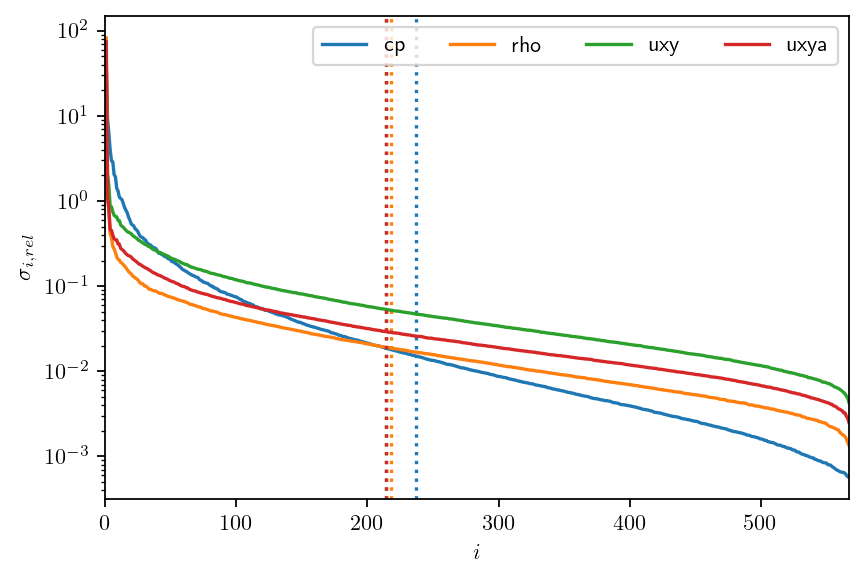

In [4]:
for i, key in enumerate(opt_ranks.keys()):
    n_s = sig_rel[key].shape[0]
    plt.plot(range(1, n_s+1), sig_rel[key], c=f"C{i}", label=key)
    plt.axvline(opt_ranks[key], ls=":", c=f"C{i}")
    
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,rel}$")
plt.legend(ncol=4)
plt.yscale("log")
plt.xlim(0, n_s)
plt.show()

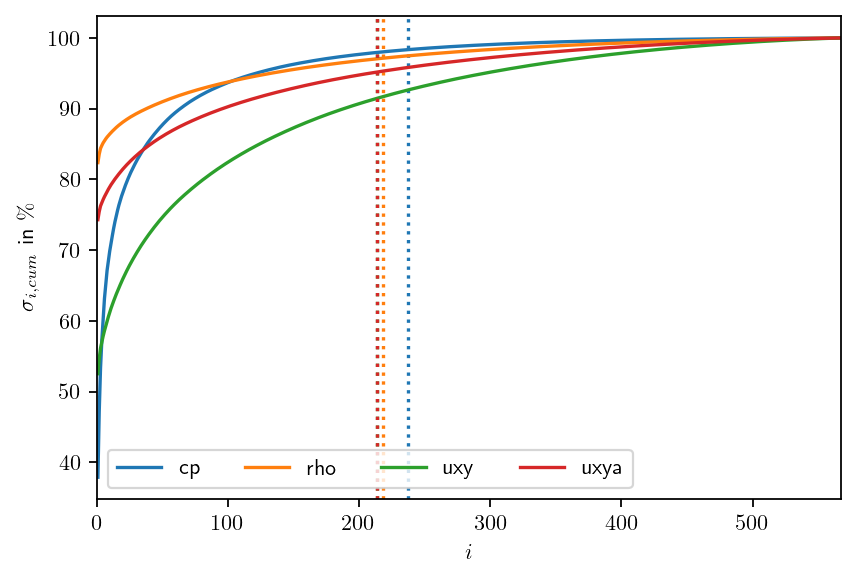

In [5]:
for i, key in enumerate(opt_ranks.keys()):
    n_s = sig_cum[key].shape[0]
    plt.plot(range(1, n_s+1), sig_cum[key], c=f"C{i}", label=key)
    plt.axvline(opt_ranks[key], ls=":", c=f"C{i}")
    
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_{i,cum}$ in $\%$")
plt.legend(ncol=4)
plt.xlim(0, n_s)
plt.show()

## Rank sensitivity

In [6]:
dmd_variants = ("DMD", "optDMD", "TDMD", "optTDMD", "UDMD", "optUDMD")
state_variants = ("cp", "rho", "uxy", "uxya")
all_variants = [f"{i[1]}_{i[0]}" for i in product(state_variants, dmd_variants)]
results = {}
for var in all_variants:
    with open(f"{path}{var}.pkl", "rb") as source:
        results[var] = pickle.load(source)
        
ranks = pt.load(f"{path}ranks_ref1_z25.pt")

### Reconstruction error

In [7]:
def plot_reconstruction_error(state, title, ybounds=None):
    for i, key in enumerate([f"{var}_{state}" for var in dmd_variants]):
        plt.plot(ranks, pt.tensor(results[key][4])/norm[state], c=f"C{i}", lw=1, label=key.split("_")[0])
    plt.axvline(opt_ranks[state], ls=":", c="k", label=r"$r_{opt}$")
    plt.yscale("log")
    plt.xlim(ranks[0], ranks[-1])
    plt.legend()
    plt.xlabel(r"$r$")
    plt.ylabel(r"$||\hat{\mathbf{M}}-\mathbf{M}||_F / ||\mathbf{M}||_F$")
    plt.title(title)
    if ybounds is not None:
        plt.ylim(*ybounds)
    plt.show()

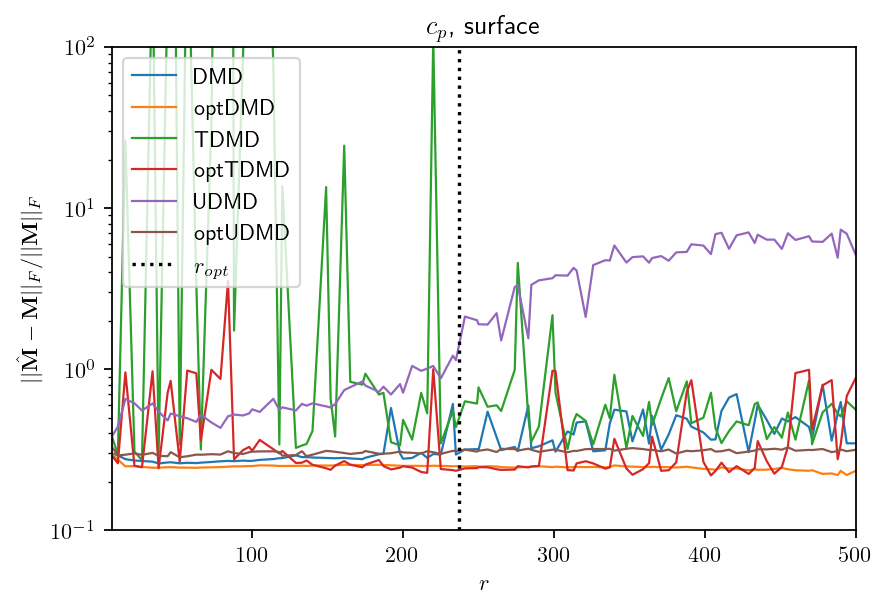

In [8]:
plot_reconstruction_error("cp", r"$c_p$, surface", (0.1, 100))

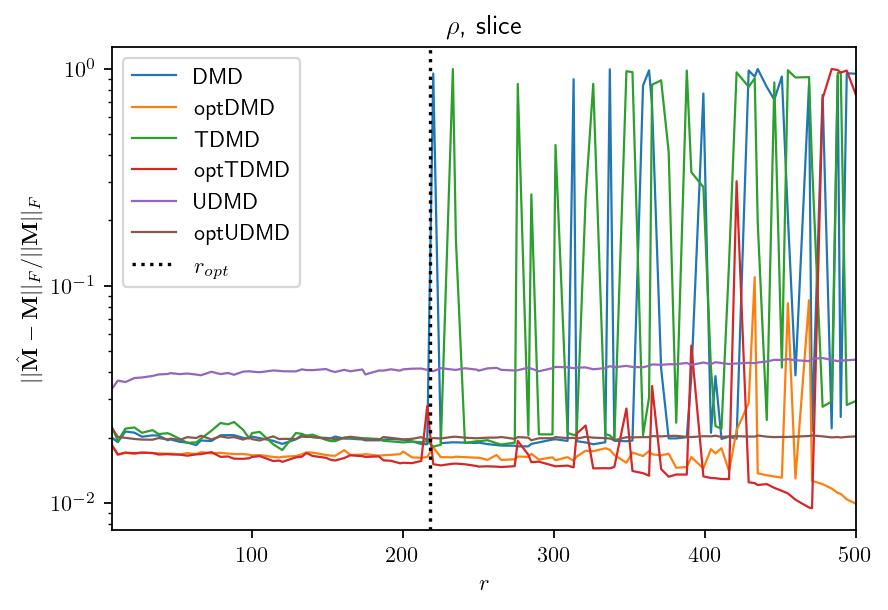

In [11]:
plot_reconstruction_error("rho", r"$\rho$, slice")

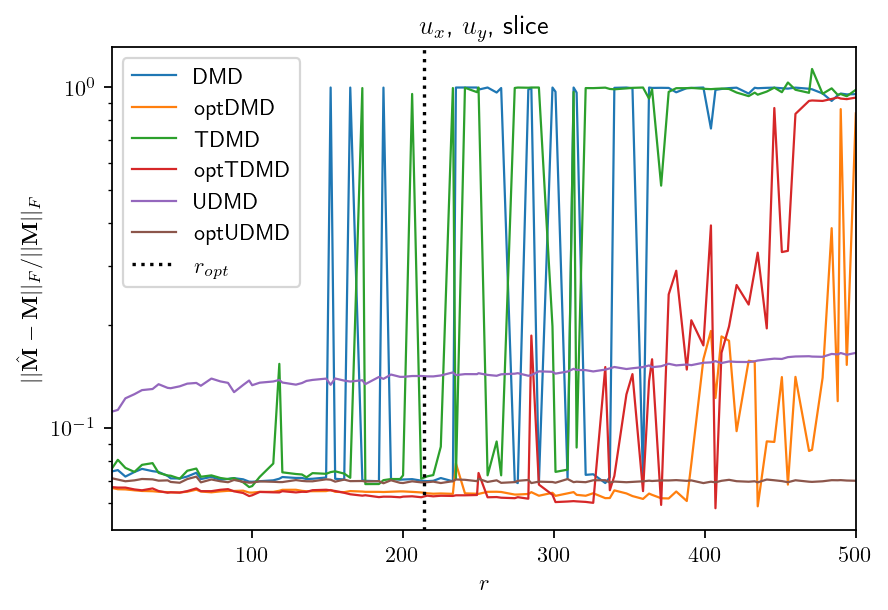

In [12]:
plot_reconstruction_error("uxy", r"$u_x$, $u_y$, slice")

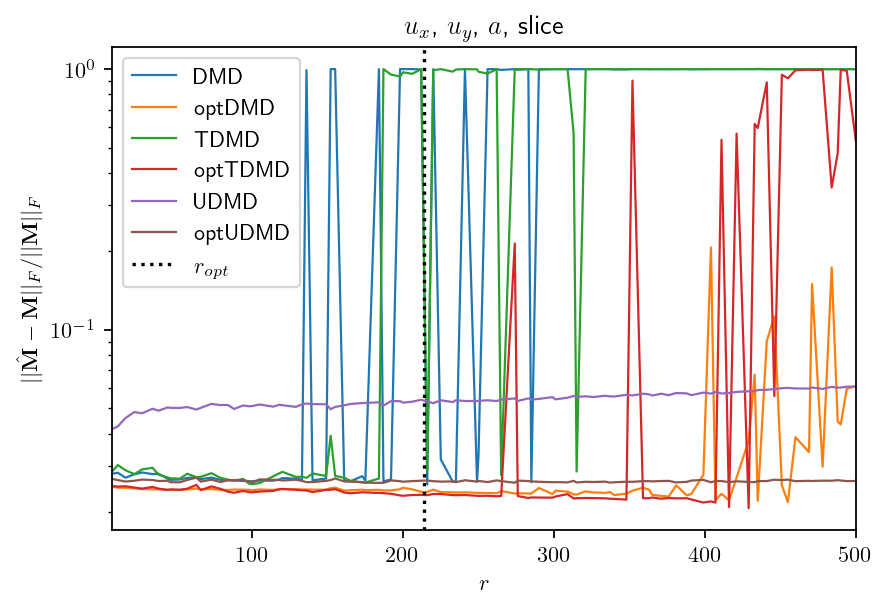

In [13]:
plot_reconstruction_error("uxya", r"$u_x$, $u_y$, $a$, slice")

### Top-k reconstruction error

In [14]:
def plot_partial_reconstruction_error(state, title, ybounds=None):
    for i, key in enumerate([f"{var}_{state}" for var in dmd_variants]):
        plt.plot(ranks, pt.tensor(results[key][5])/norm[state], c=f"C{i}", lw=1, label=key.split("_")[0])
        plt.plot(ranks, pt.tensor(results[key][6])/norm[state], c=f"C{i}", ls="--", lw=1)
    plt.axvline(opt_ranks[state], ls=":", c="k", label=r"$r_{opt}$")
    plt.yscale("log")
    plt.xlim(ranks[0], ranks[-1])
    handles, labels = plt.gca().get_legend_handles_labels()
    line = mpl.lines.Line2D([0], [0], label='int. criterion', lw=1, ls="--", color='k')
    handles.extend([line])
    plt.legend(handles=handles)
    plt.xlabel(r"$r$")
    plt.ylabel(r"$||\hat{\mathbf{M}}-\mathbf{M}||_F / ||\mathbf{M}||_F$")
    plt.title(title)
    if ybounds is not None:
        plt.ylim(*ybounds)
    plt.show()

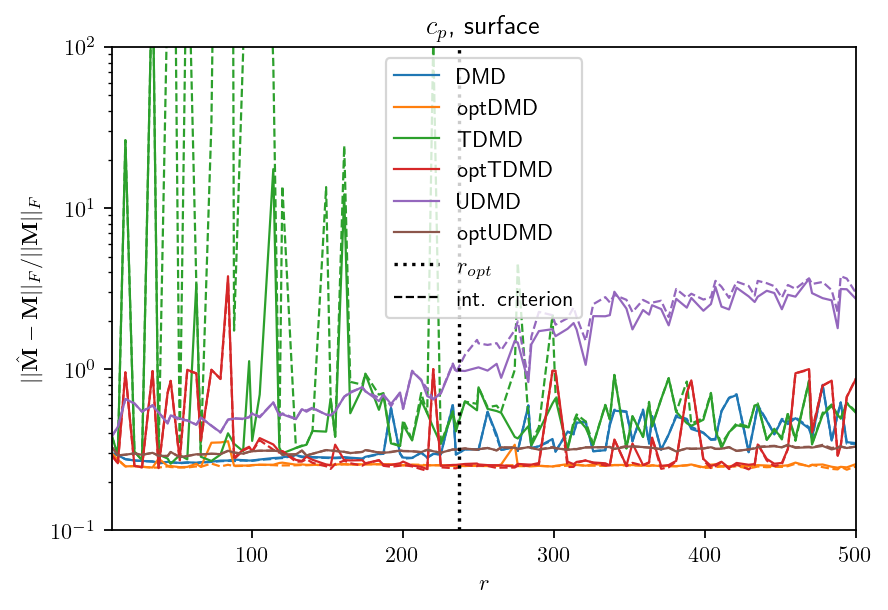

In [15]:
plot_partial_reconstruction_error("cp", r"$c_p$, surface", (0.1, 100))

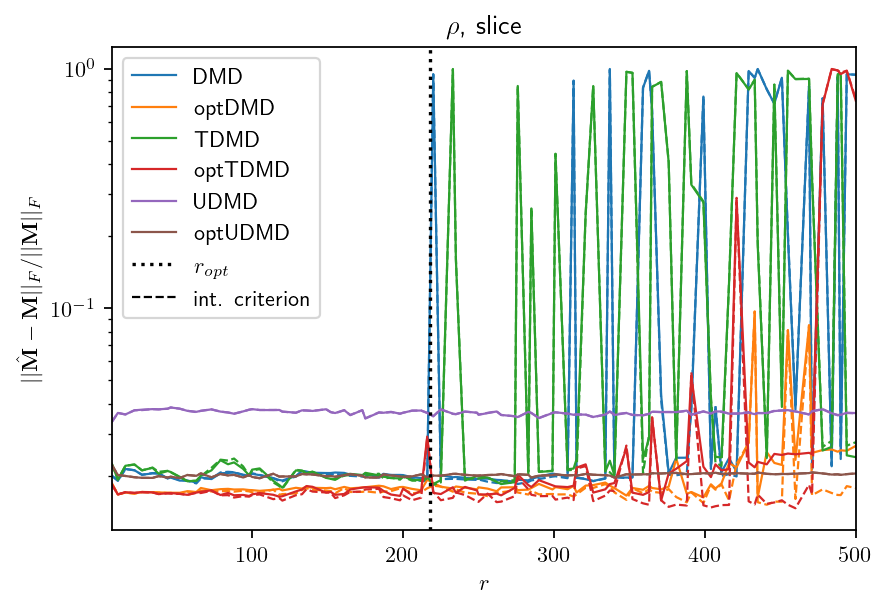

In [16]:
plot_partial_reconstruction_error("rho", r"$\rho$, slice")

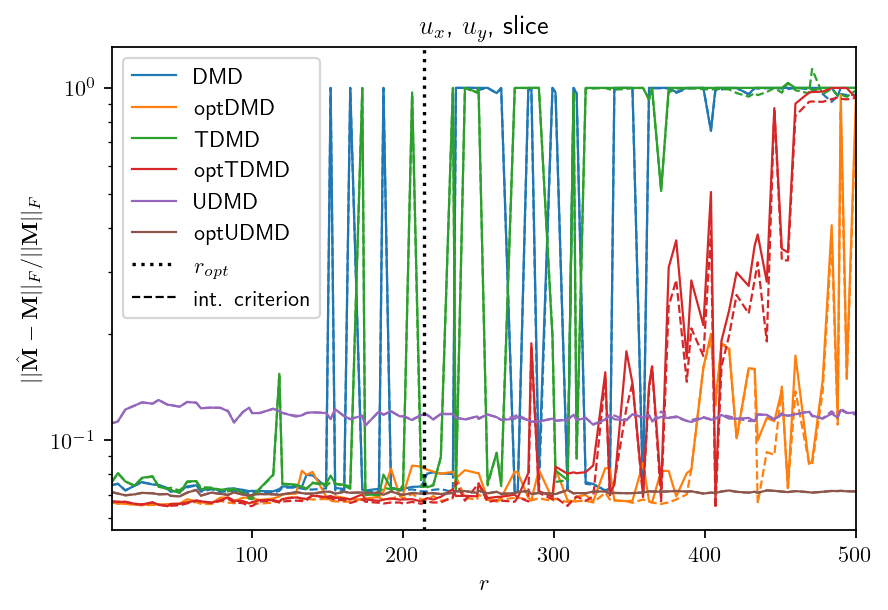

In [17]:
plot_partial_reconstruction_error("uxy", r"$u_x$, $u_y$, slice")

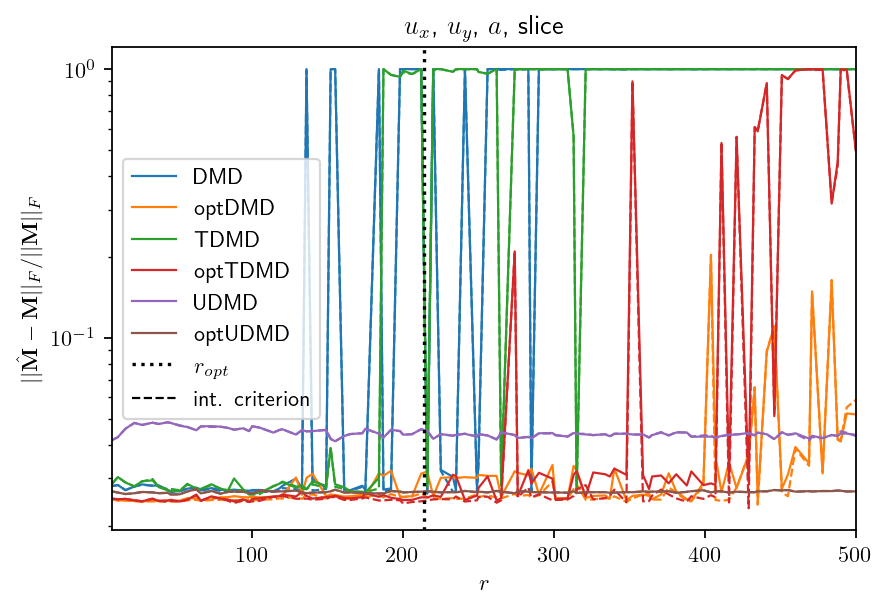

In [18]:
plot_partial_reconstruction_error("uxya", r"$u_x$, $u_y$, $a$, slice")

### Eigenvalues

In [19]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Code copied from:
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                                  facecolor=facecolor, zorder=8, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = mpl.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [45]:
TOL = 1.0

def extract_top_eigval(key):
    er_amp, ei_amp, er_int, ei_int = [], [], [], []
    e, f, si, sa = results[key][:4]
    for i in range(ranks.shape[0]):
        top_a = pt.tensor([j for j in sa[i] if f[i][j] > TOL], dtype=pt.int64)
        top_i = pt.tensor([j for j in si[i] if f[i][j] > TOL], dtype=pt.int64)
        er_amp.append(e[i][top_a[0]].real.item())
        ei_amp.append(e[i][top_a[0]].imag.item())
        er_int.append(e[i][top_i[0]].real.item())
        ei_int.append(e[i][top_i[0]].imag.item())
    return er_amp, ei_amp, er_int, ei_int

def plot_eigvals(state):
    fig, axarr = plt.subplots(4, 3, figsize=(6, 8), sharex=True, sharey=True)
    t = pt.linspace(0, 2 * np.pi, 100)
    for ax in axarr.flatten():
        ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
        ax.set_aspect("equal")
        ax.set_xlim(0.95, 1.05)
        ax.set_ylim(0.0, 0.1)
    for ax in axarr[-1, :]:
        ax.set_xlabel(r"$\Re(\lambda)$")
    for ax in axarr[:, 0]:
        ax.set_ylabel(r"$\Im(\lambda)$")
    
    for i, key in enumerate(("DMD", "TDMD", "UDMD")):
        # standard
        er_amp, ei_amp, er_int, ei_int = extract_top_eigval(f"{key}_{state}")
        axarr[0, i].scatter(er_amp, ei_amp, c="C0", marker="o", s=10, alpha=0.3, zorder=7)
        axarr[1, i].scatter(er_int, ei_int, c="C0", marker="o", s=10, alpha=0.3, zorder=7)
        confidence_ellipse(np.array(er_amp), np.array(ei_amp), axarr[0, i], n_std=2, edgecolor="C3")
        confidence_ellipse(np.array(er_int), np.array(ei_int), axarr[1, i], n_std=2, edgecolor="C3")
        axarr[0, i].scatter([sum(er_amp)/len(er_amp)], [sum(ei_amp)/len(ei_amp)], c=f"C3", s=30, marker="*", zorder=8)
        axarr[1, i].scatter([sum(er_int)/len(er_int)], [sum(ei_int)/len(ei_int)], c=f"C3", s=30, marker="*", zorder=8)
        axarr[0, i].set_title(f"{key}, amp.")
        axarr[1, i].set_title(f"{key}, int.")
        #optimal
        er_amp, ei_amp, er_int, ei_int = extract_top_eigval(f"opt{key}_{state}")
        axarr[2, i].scatter(er_amp, ei_amp, c="C0", marker="o", s=10, alpha=0.3, zorder=7)
        axarr[3, i].scatter(er_int, ei_int, c="C0", marker="o", s=10, alpha=0.3, zorder=7)
        confidence_ellipse(np.array(er_amp), np.array(ei_amp), axarr[2, i], n_std=2, edgecolor="C3")
        confidence_ellipse(np.array(er_int), np.array(ei_int), axarr[3, i], n_std=2, edgecolor="C3")
        axarr[2, i].scatter([sum(er_amp)/len(er_amp)], [sum(ei_amp)/len(ei_amp)], c=f"C3", s=30, marker="*", edgecolor="C3", zorder=9)
        axarr[3, i].scatter([sum(er_int)/len(er_int)], [sum(ei_int)/len(ei_int)], c=f"C3", s=30, marker="*", edgecolor="C3", zorder=9)
        axarr[2, i].set_title(f"opt. {key}, amp.")
        axarr[3, i].set_title(f"opt. {key}, int.")
    line = plt.Line2D([0.02, 0.9], [0.51, 0.51], ls=":", transform=fig.transFigure, color="black", alpha=0.5)
    fig.add_artist(line)
    plt.subplots_adjust(hspace=0.3)
    plt.savefig(f"{path}{state}_eigvals.pdf", bbox_inches="tight")
    plt.show()

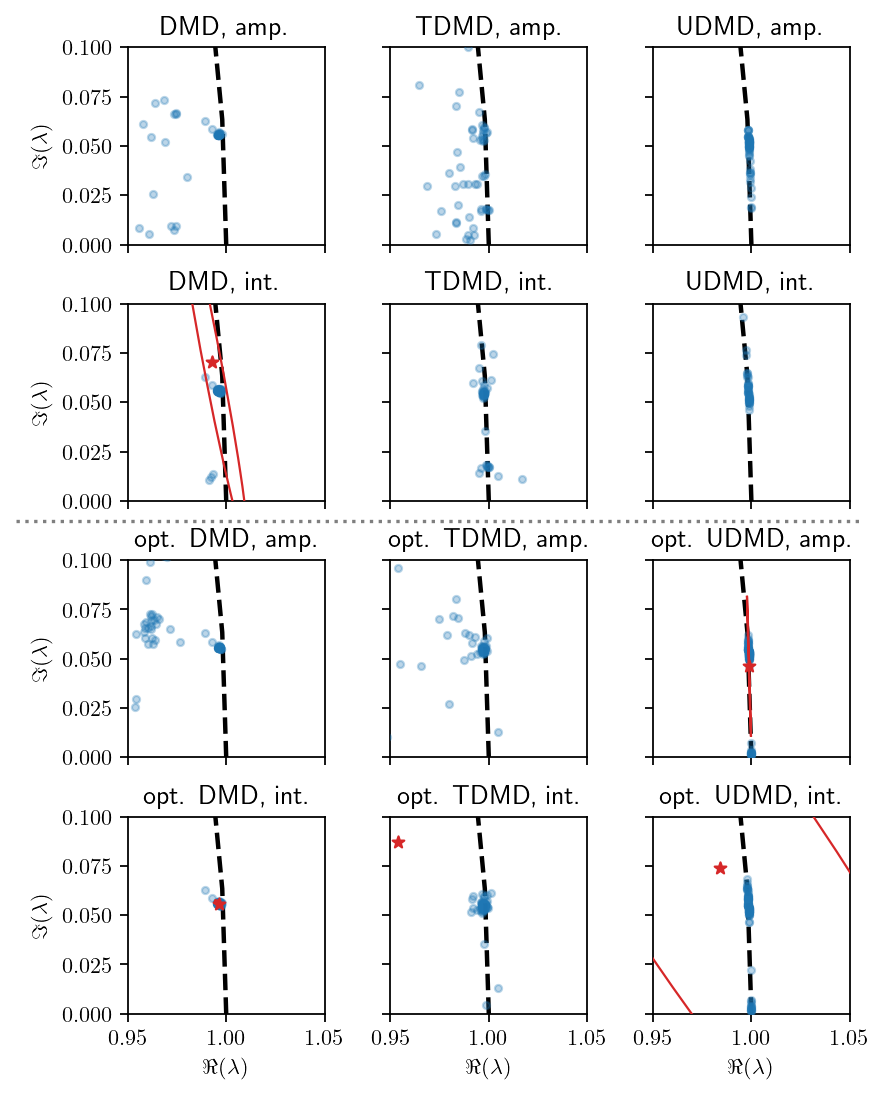

In [46]:
plot_eigvals("cp")

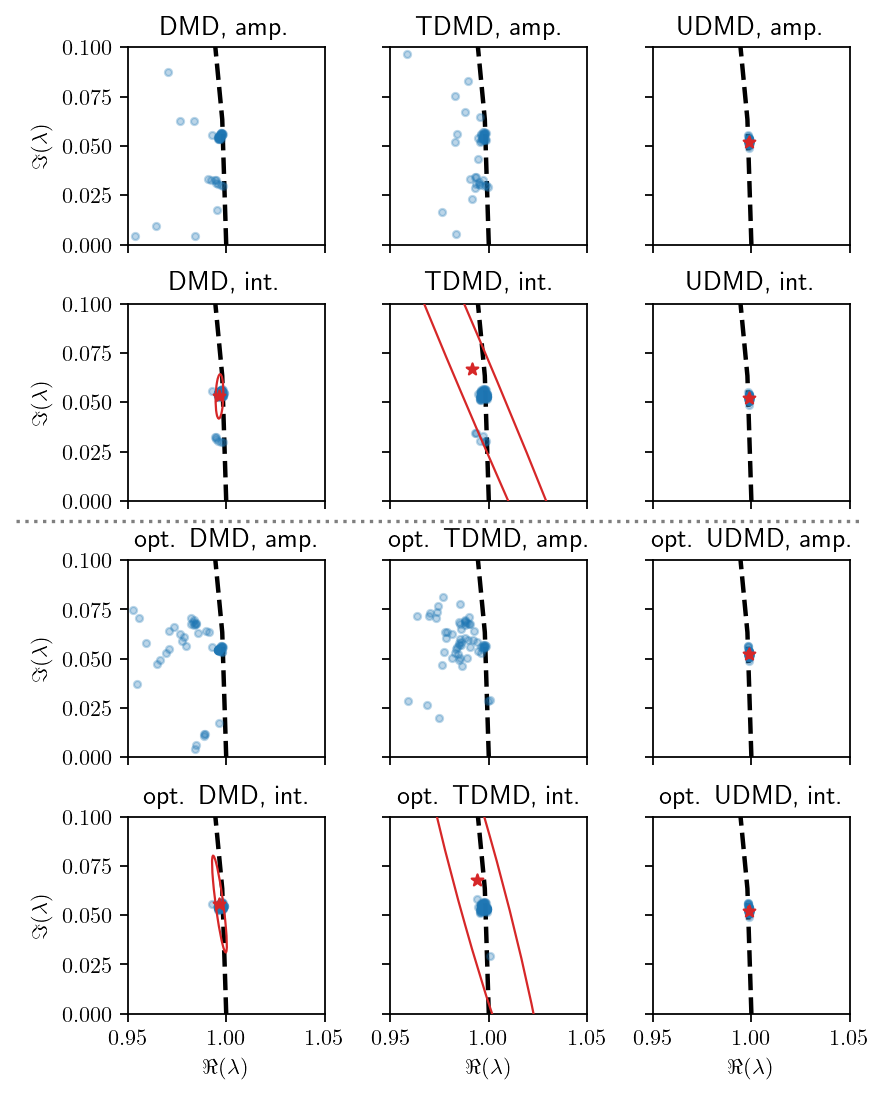

In [47]:
plot_eigvals("rho")

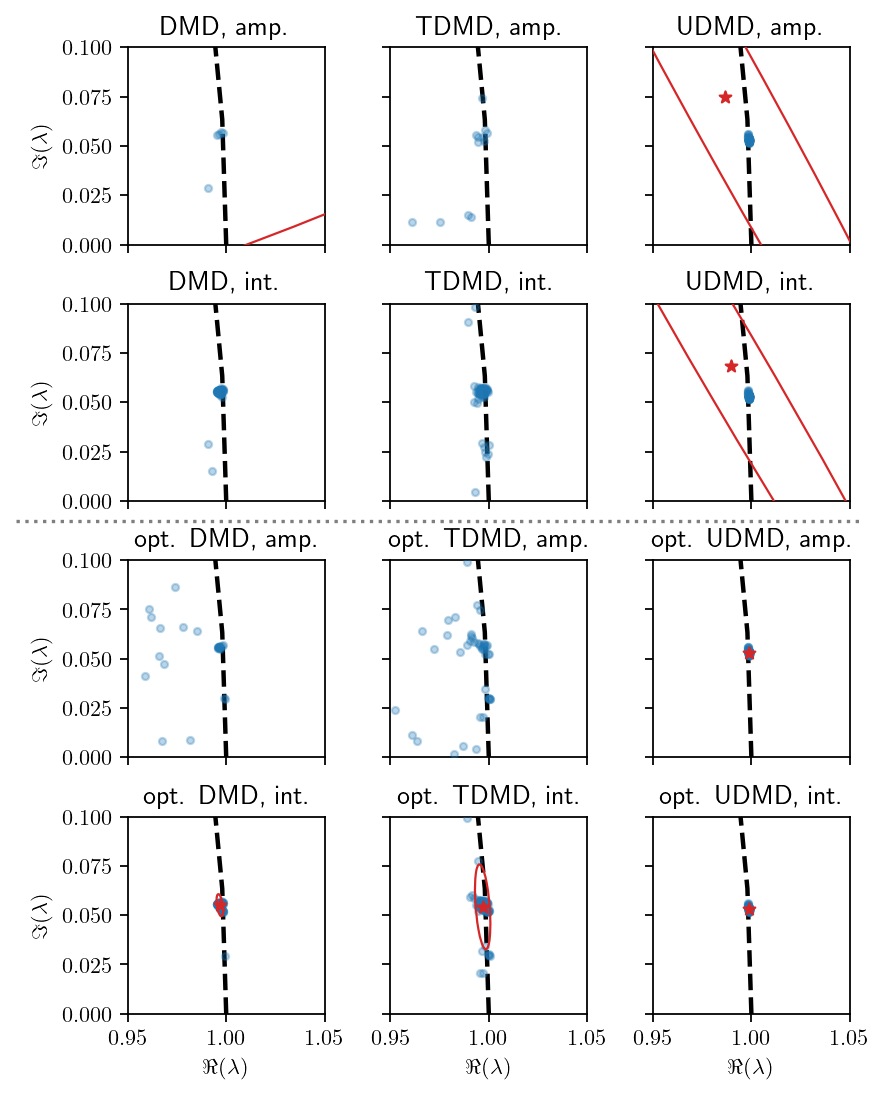

In [48]:
plot_eigvals("uxy")

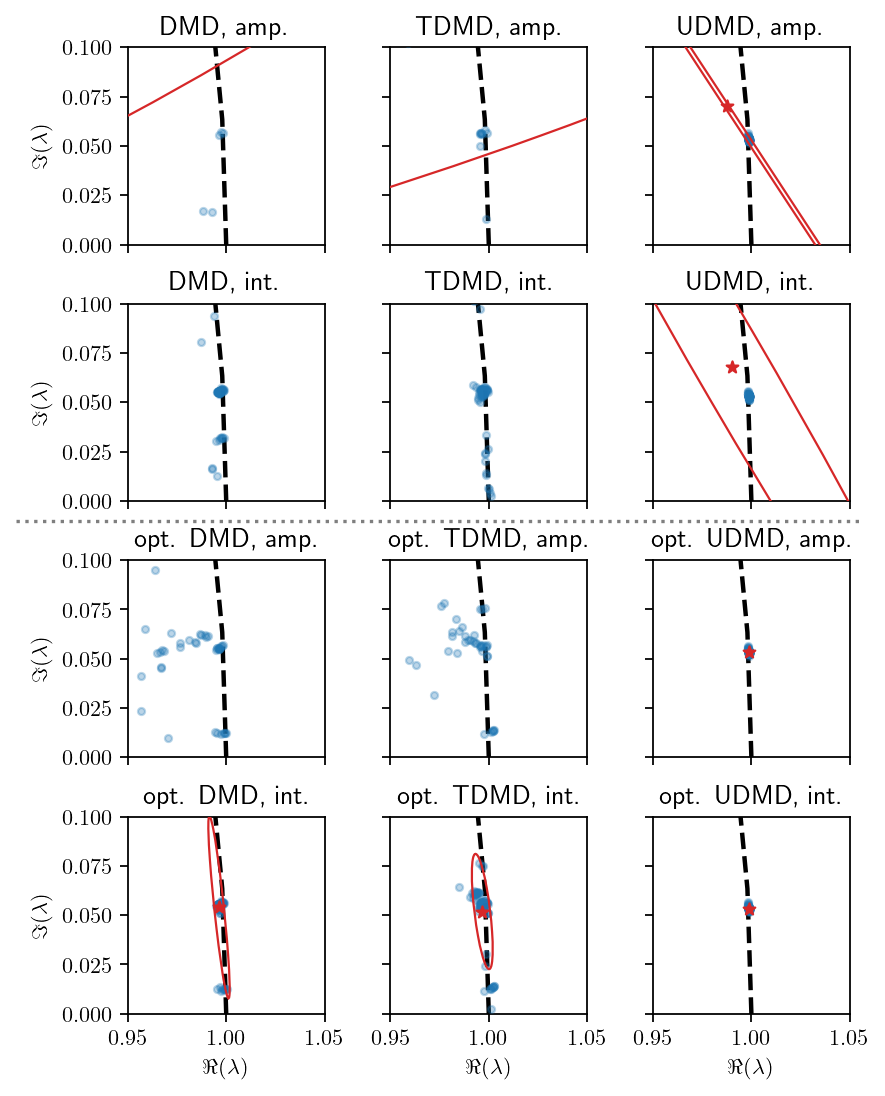

In [49]:
plot_eigvals("uxya")

### Buffet frequency

In [52]:
def extract_top_freq(key):
    f_a, f_i = [], []
    e, f, si, sa = results[key][:4]
    for i in range(ranks.shape[0]):
        top_a = pt.tensor([j for j in sa[i] if f[i][j] > TOL], dtype=pt.int64)
        top_i = pt.tensor([j for j in si[i] if f[i][j] > TOL], dtype=pt.int64)
        f_a.append(f[i][top_a[0]].item())
        f_i.append(f[i][top_i[0]].item())
    return f_a, f_i

def plot_frequency(state):
    fig, axarr = plt.subplots(3, 1, figsize=(6, 5), sharex=True, sharey=True)
    fb = 0.65173183
    fbmax = fb * 1.5
    fbmin = fb * 0.5
    for i, key in enumerate(("DMD", "TDMD", "UDMD")):
        f_a, f_i =  extract_top_freq(f"{key}_{state}")
        axarr[i].scatter(ranks, np.clip(normalize_frequency(np.array(f_a)), fbmin, fbmax), lw=1, s=20, marker="o", label=r"amp.")
        axarr[i].scatter(ranks, np.clip(normalize_frequency(np.array(f_i)), fbmin, fbmax), lw=1, s=20, marker="*", label=r"int.")
        f_a, f_i =  extract_top_freq(f"opt{key}_{state}")
        axarr[i].scatter(ranks, np.clip(normalize_frequency(np.array(f_a)), fbmin, fbmax), lw=1, s=20, marker="x", label=r"opt., amp.")
        axarr[i].scatter(ranks, np.clip(normalize_frequency(np.array(f_i)), fbmin, fbmax), lw=1, s=20, marker="+", label=r"opt., int.")
        

        axarr[i].axhline(fb, ls="--", c="k", label=r"$\tilde{f}_b$")
        axarr[i].axvline(opt_ranks[state], ls=":", c="k")
        axarr[i].text(opt_ranks[state]-15, 0.5*(fb+fbmax), r"$r_{\mathrm{opt}}$", rotation=90, va="center")
        if i == 0:
            axarr[i].legend(ncol=5, loc="upper center", fontsize=10, bbox_to_anchor=(0.5, 1.3))
        axarr[i].text(510, fb, key, rotation=90, va="center")
        axarr[i].set_ylabel(r"$\tilde{f}_{\mathrm{max}}$")
        axarr[i].set_ylim(fbmin, fbmax)
    axarr[-1].set_xlabel(r"$r$")
    axarr[-1].set_xlim(ranks[0], ranks[-1])
    plt.savefig(f"{path}{state}_freq.pdf", bbox_inches="tight")
    plt.show()

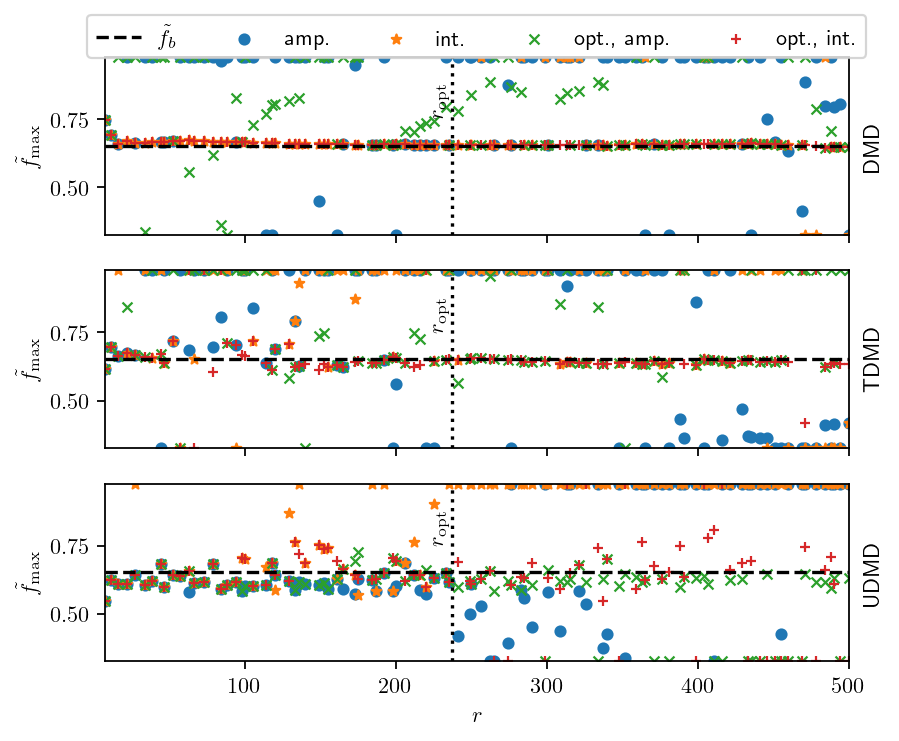

In [53]:
plot_frequency("cp")

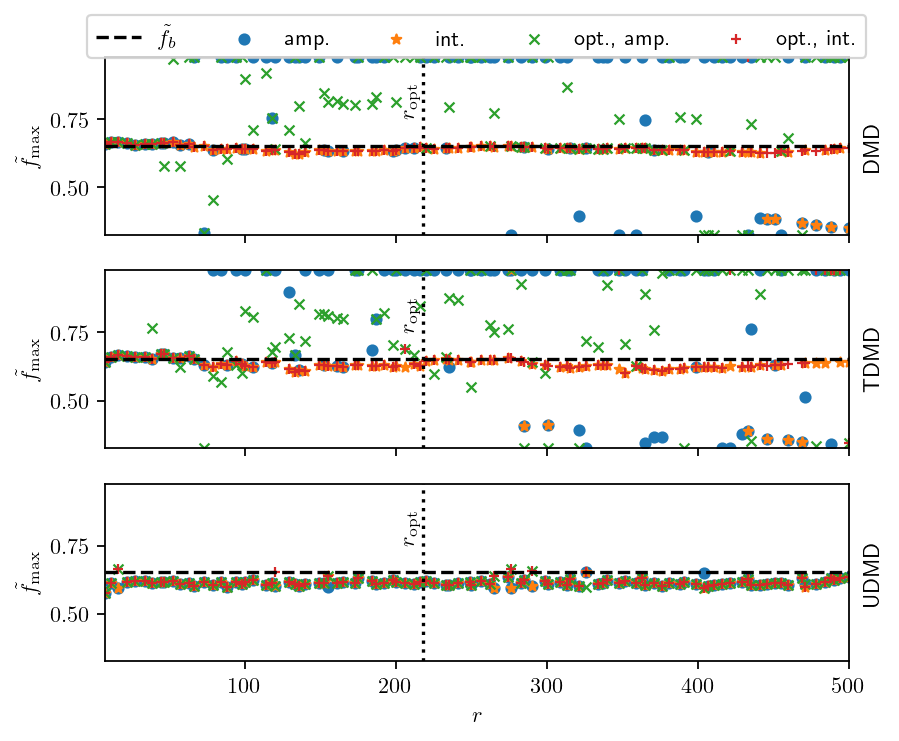

In [54]:
plot_frequency("rho")

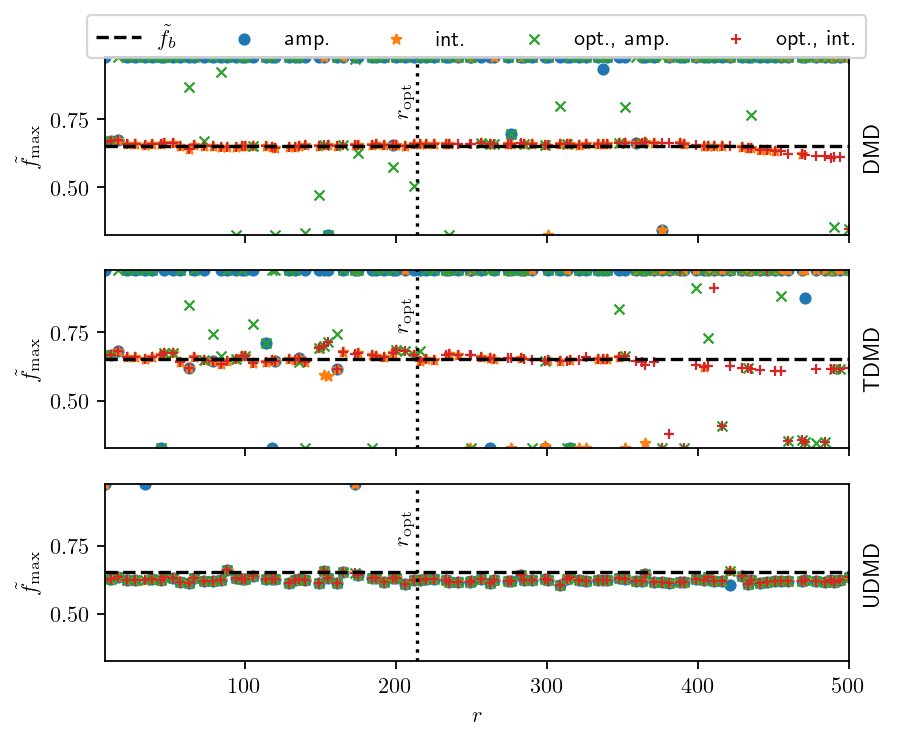

In [55]:
plot_frequency("uxy")

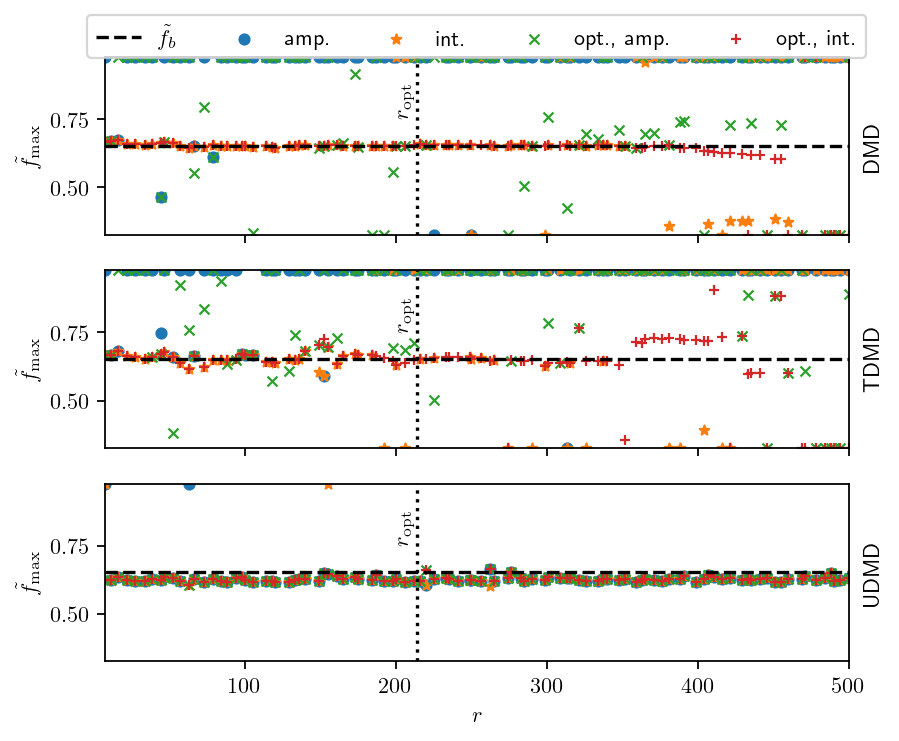

In [56]:
plot_frequency("uxya")

## Number of snapshots

In [60]:
dmd_variants = ("optDMD", "optTDMD", "optUDMD")
state_variants = ("cp", "rho", "uxy", "uxya")
all_variants = [f"{i[1]}_{i[0]}" for i in product(state_variants, dmd_variants)]
results = {}
for var in all_variants:
    with open(f"{path}{var}_snapshots.pkl", "rb") as source:
        results[var] = pickle.load(source)

In [61]:
TOL = 1.0
every = (1, 2, 4, 8, 16, 32, 64)
n_cycles = 5
n_snap = [len(times[::e]) for e in every]
n_snap_cycle = [int(n_s / n_cycles) for n_s in n_snap]
dt = times[1] - times[0]
f_max = normalize_frequency(pt.tensor([1.0 / (2.0*e*dt) for e in every]))

def extract_top_k_freq(key, k):
    f_i = []
    _, f, si = results[key][:3]
    for i in range(len(every)):
        top_i = pt.tensor([j for j in si[i] if f[i][j] > TOL], dtype=pt.int64)
        f_i.append(f[i][top_i[:k]])
    return f_i

In [62]:
f_max

tensor([73.9855, 36.9927, 18.4964,  9.2482,  4.6241,  2.3120,  1.1560])

In [63]:
def plot_topk_frequencies(data_key, k, title):
    markers = ("o", "x", "+")
    fb = 0.65173183
    for i, dmd_i in enumerate(("DMD", "TDMD", "UDMD")):
        label_set = False
        f = extract_top_k_freq(f"opt{dmd_i}_{data_key}", k)
        for n_s, f_j in zip(n_snap_cycle, f):
            n_f = f_j.shape[0]
            if not label_set:
                plt.scatter(pt.ones(n_f) * n_s, normalize_frequency(f_j), lw=1, marker=markers[i], c=f"C{i}", s=20, label=dmd_i)
                label_set = True
            else:
                plt.scatter(pt.ones(n_f) * n_s, normalize_frequency(f_j), lw=1, marker=markers[i], c=f"C{i}", s=20)
    plt.plot(n_snap_cycle, f_max, ls="--", c="k", label=r"$\tilde{f}_{\mathrm{Nyquist}}$")
    plt.axhline(fb, ls=":", c="k", label=r"$\tilde{f}_b$")
    plt.xlabel(r"$\tilde{f}_s/\tilde{f}_{b}$")
    plt.ylabel(r"$\tilde{f}$")
    plt.legend()
    plt.ylim(0.1, f_max[0])
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.savefig(f"{path}{data_key}_topk_frequency.pdf", bbox_inches="tight")
    plt.show()

In [64]:
n_show = 10

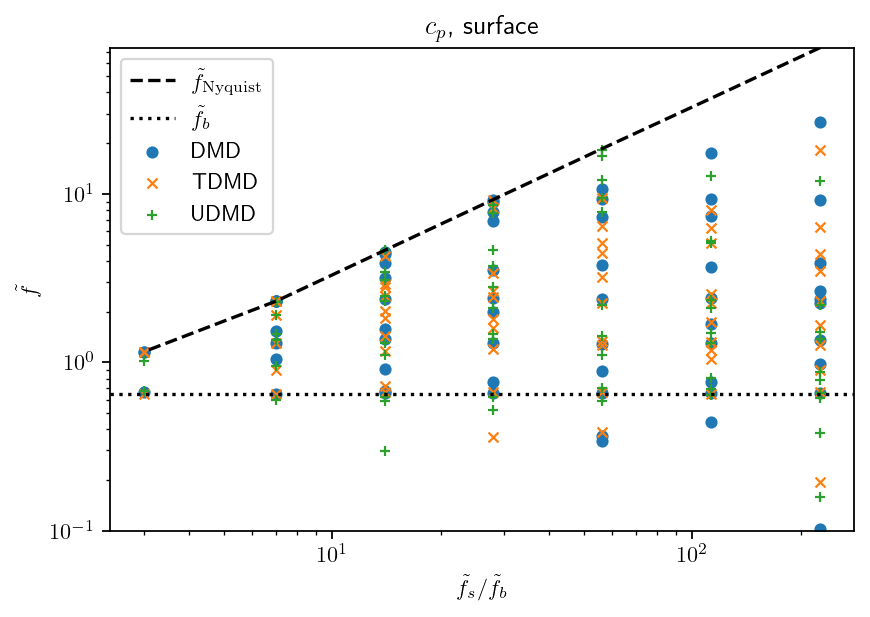

In [65]:
plot_topk_frequencies("cp", n_show, r"$c_p$, surface")

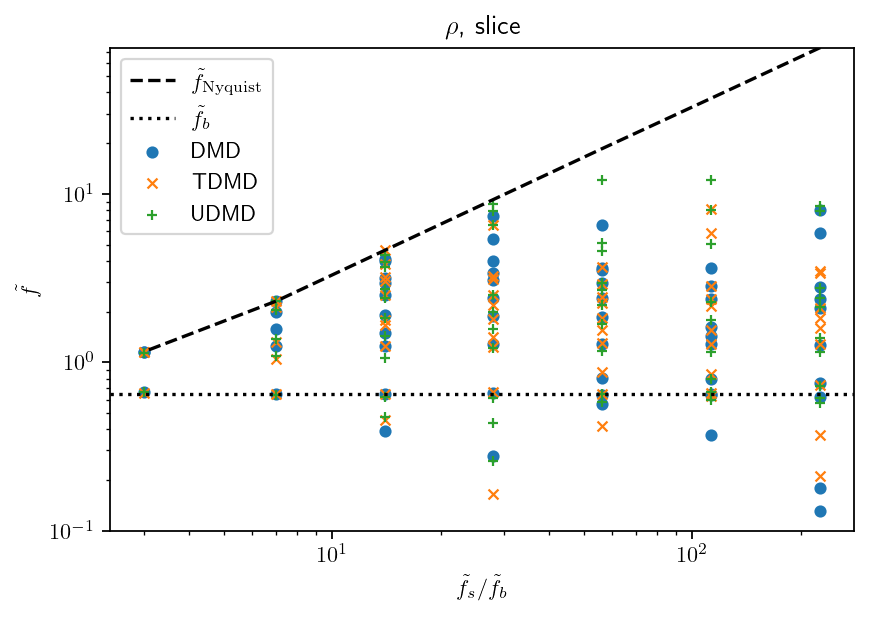

In [66]:
plot_topk_frequencies("rho", n_show, r"$\rho$, slice")

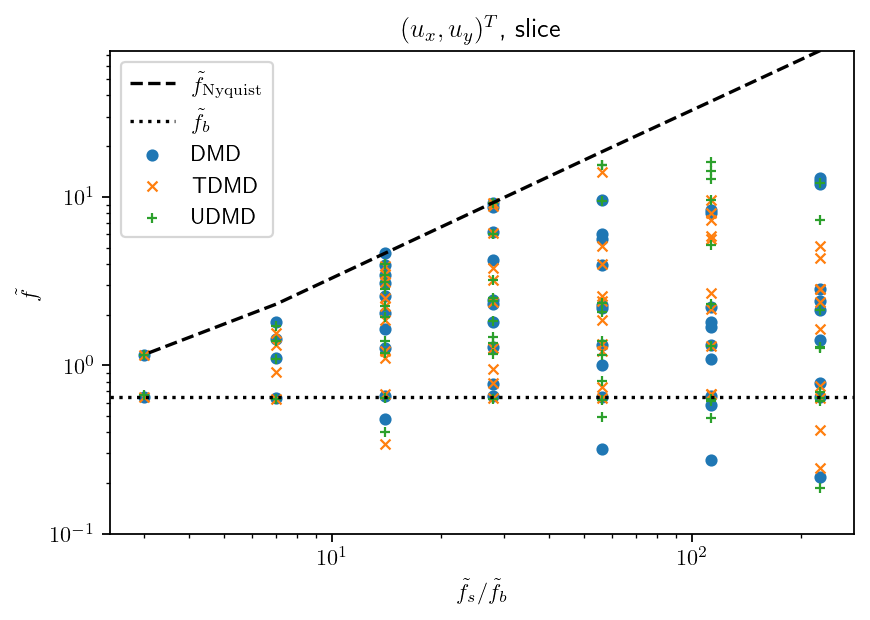

In [69]:
plot_topk_frequencies("uxy", n_show, r"$(u_x, u_y)^T$, slice")

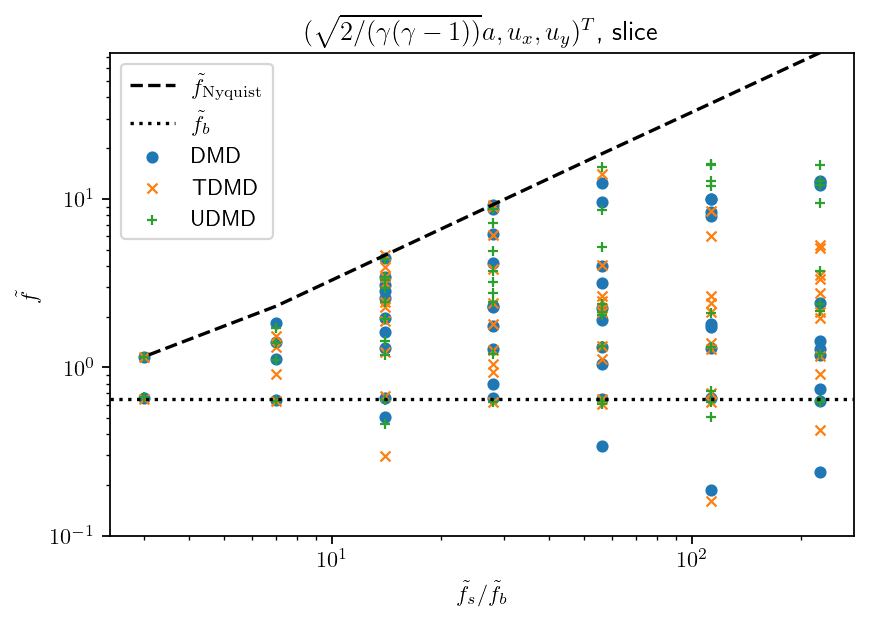

In [70]:
plot_topk_frequencies("uxya", n_show, r"$(\sqrt{2/(\gamma (\gamma -1))} a, u_x, u_y)^T$, slice")